Sustain but with a combination of left and right regions.

How? we will begin by just taking the mean of the left and riught. We could do the sum but this feels wrong.

We also need to think what to do with those that dont have left and right


In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import sklearn.model_selection
import pandas as pd
import pylab
import sys
import seaborn as sns
import statsmodels.formula.api as smf
from scipy import stats
from pySuStaIn import ZscoreSustain

import mrmr


c:\Users\huw\OneDrive\Documents\Research_Internship\MPhys_scripts\.conda\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
data_dir = 'data'

df = pd.read_csv(os.path.join(data_dir, 'huw_whole_df.csv'), index_col = 0)

dx_map = {
    0: 0,
    1 : 1,
    2 : 2,
    3 : 2,
}


df['DX_bl'] = df['DX_bl'].map(dx_map)

df['DX_bl'].value_counts()

df.loc[(df['ABETA_bl'] == 1700) & (df['DX_bl'] == 2), 'DX_bl'] = 3


df_1 = df.drop(columns=['PTEDUCAT','TAU_bl','PTAU_bl','ABETA_bl', 'MMSE_bl','EcogPtTotal_bl', 'LDELTOTAL_BL', 'mPACCdigit_bl', 'mPACCtrailsB_bl', 'RAVLT_immediate_bl', 'RAVLT_learning_bl', 'RAVLT_forgetting_bl','PTID', 'EXAMDATE', 'EXAMDATE_bl', 'DX','AGE', 'PTGENDER', 'PTRACCAT', 'FHQMOM', 'FHQDAD', 'FHQMOMAD', 'FHQDADAD', 'RAVLT_perc_forgetting_bl'])

df_1

,DX_bl,SUVr_ACC_pre_L.nii,SUVr_ACC_pre_R.nii,SUVr_ACC_sub_L.nii,SUVr_ACC_sub_R.nii,SUVr_ACC_sup_L.nii,SUVr_ACC_sup_R.nii,SUVr_Amygdala_L.nii,SUVr_Amygdala_R.nii,SUVr_Angular_L.nii,...,SUVr_Vermis_1_2.nii,SUVr_Vermis_3.nii,SUVr_Vermis_4_5.nii,SUVr_Vermis_6.nii,SUVr_Vermis_7.nii,SUVr_Vermis_8.nii,SUVr_Vermis_9.nii,SUVr_Vermis_10.nii,SUVr_VTA_L.nii,SUVr_VTA_R.nii
1,2,0.033800,0.042295,0.010627,0.008586,0.039320,0.038841,0.011054,0.014155,0.058692,...,0.003369,0.011351,0.030880,0.018253,0.009289,0.011917,0.008881,0.006231,0.000712,0.000659
2,2,0.056520,0.063619,0.016490,0.012617,0.057261,0.053242,0.013008,0.017184,0.108759,...,0.003325,0.011246,0.029007,0.016903,0.009108,0.012666,0.008033,0.006029,0.000770,0.000699
3,0,0.060682,0.068784,0.017864,0.013864,0.054272,0.053113,0.013620,0.016730,0.104904,...,0.003402,0.011694,0.033622,0.019224,0.010413,0.012902,0.007799,0.005730,0.000804,0.000760
4,2,0.042112,0.049571,0.011925,0.010232,0.044834,0.042373,0.011938,0.015462,0.067635,...,0.003367,0.011986,0.034076,0.019834,0.010011,0.012782,0.009789,0.006613,0.000748,0.000675
5,2,0.041158,0.046395,0.012714,0.009992,0.042674,0.039067,0.011457,0.013684,0.073826,...,0.002935,0.009448,0.028740,0.017897,0.009361,0.012595,0.008533,0.005170,0.000675,0.000675
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
542,3,0.044351,0.052593,0.011514,0.010009,0.042117,0.045545,0.013725,0.016478,0.062204,...,0.003873,0.012135,0.034131,0.018864,0.008398,0.011478,0.009674,0.007555,0.000818,0.000764
543,3,0.036909,0.047695,0.011225,0.008871,0.040523,0.041999,0.011000,0.014486,0.076857,...,0.003308,0.010313,0.029413,0.016943,0.008936,0.011930,0.008579,0.006243,0.000678,0.000581
544,3,0.038544,0.048572,0.012500,0.010097,0.046125,0.047444,0.010035,0.012790,0.074429,...,0.003723,0.011469,0.026939,0.015693,0.008374,0.011329,0.008016,0.006976,0.000753,0.000723
545,3,0.029956,0.041714,0.009979,0.008269,0.035993,0.039143,0.010660,0.014074,0.065539,...,0.003486,0.011536,0.031103,0.017387,0.008620,0.010525,0.007063,0.005713,0.000815,0.000768


In [3]:
suvr_cols = [col for col in df.columns if col.startswith("SUVr")]

suvr_cols = [col.replace('SUVr_', '') for col in suvr_cols]

suvr_cols = [col.replace('.nii', '') for col in suvr_cols]

In [4]:
lr = [col for col in suvr_cols if col.endswith('_L') or col.endswith('_R')]
non_lr = [col for col in suvr_cols if col not in lr]
print(len(lr)/2 + (len(non_lr)))



88.0


In [5]:
df_2 = pd.DataFrame(index=df.index)

new_suvr_cols = []

for i in range(len(lr)):
    for j in range(i + 1, len(lr)):
        base_i = lr[i][:-2]
        base_j = lr[j][:-2]
        
        if base_i == base_j:
            mean = (df_1['SUVr_'+lr[i]+'.nii'] + df_1['SUVr_'+lr[j]+'.nii']) / 2
            df_2[base_i] = mean
            new_suvr_cols.append(base_i)
            
for col in non_lr:
    df_2[col] = df_1['SUVr_'+col+'.nii']
    new_suvr_cols.append(col)

In [6]:
for col in new_suvr_cols:
    print(col)
    
print(len(new_suvr_cols))

ACC_pre
ACC_sub
ACC_sup
Amygdala
Angular
Calcarine
Caudate
Cerebellum_3
Cerebellum_4_5
Cerebellum_6
Cerebellum_7b
Cerebellum_8
Cerebellum_9
Cerebellum_10
Cerebellum_Crus1
Cerebellum_Crus2
Cingulate_Mid
Cingulate_Post
Cuneus
Frontal_Inf_Oper
Frontal_Inf_Orb_2
Frontal_Inf_Tri
Frontal_Med_Orb
Frontal_Mid_2
Frontal_Sup_2
Frontal_Sup_Medial
Fusiform
Heschl
Hippocampus
Insula
LC
Lingual
N_Acc
Occipital_Inf
Occipital_Mid
Occipital_Sup
OFCant
OFClat
OFCmed
OFCpost
Olfactory
Pallidum
Paracentral_Lobule
ParaHippocampal
Parietal_Inf
Parietal_Sup
Postcentral
Precentral
Precuneus
Putamen
Rectus
Red_N
Rolandic_Oper
SN_pc
SN_pr
Supp_Motor_Area
SupraMarginal
Temporal_Inf
Temporal_Mid
Temporal_Pole_Mid
Temporal_Pole_Sup
Temporal_Sup
Thal_AV
Thal_IL
Thal_LGN
Thal_LP
Thal_MDl
Thal_MDm
Thal_MGN
Thal_PuA
Thal_PuI
Thal_PuL
Thal_PuM
Thal_Re
Thal_VA
Thal_VL
Thal_VPL
VTA
Raphe_D
Raphe_M
Vermis_1_2
Vermis_3
Vermis_4_5
Vermis_6
Vermis_7
Vermis_8
Vermis_9
Vermis_10
88


In [7]:
df = df.merge(df_2, left_index=True, right_index=True, how='left')

In [8]:
df_3 = df[new_suvr_cols + ['DX_bl']]

df_3.drop(['DX_bl'], axis=1)

,ACC_pre,ACC_sub,ACC_sup,Amygdala,Angular,Calcarine,Caudate,Cerebellum_3,Cerebellum_4_5,Cerebellum_6,...,Raphe_D,Raphe_M,Vermis_1_2,Vermis_3,Vermis_4_5,Vermis_6,Vermis_7,Vermis_8,Vermis_9,Vermis_10
1,0.038048,0.009606,0.039081,0.012605,0.071256,0.118833,0.046443,0.012202,0.054710,0.088160,...,0.001606,0.000634,0.003369,0.011351,0.030880,0.018253,0.009289,0.011917,0.008881,0.006231
2,0.060070,0.014553,0.055252,0.015096,0.133972,0.177231,0.056258,0.011387,0.051079,0.086121,...,0.001624,0.000522,0.003325,0.011246,0.029007,0.016903,0.009108,0.012666,0.008033,0.006029
3,0.064733,0.015864,0.053693,0.015175,0.118836,0.172528,0.045670,0.012109,0.055388,0.094233,...,0.001913,0.000608,0.003402,0.011694,0.033622,0.019224,0.010413,0.012902,0.007799,0.005730
4,0.045841,0.011078,0.043604,0.013700,0.084240,0.136790,0.055279,0.011085,0.054308,0.099386,...,0.001570,0.000580,0.003367,0.011986,0.034076,0.019834,0.010011,0.012782,0.009789,0.006613
5,0.043776,0.011353,0.040871,0.012570,0.085346,0.128913,0.038908,0.010261,0.051112,0.087694,...,0.001492,0.000534,0.002935,0.009448,0.028740,0.017897,0.009361,0.012595,0.008533,0.005170
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
542,0.048472,0.010762,0.043831,0.015101,0.073510,0.138964,0.061131,0.013363,0.057152,0.100256,...,0.001824,0.000717,0.003873,0.012135,0.034131,0.018864,0.008398,0.011478,0.009674,0.007555
543,0.042302,0.010048,0.041261,0.012743,0.097817,0.133770,0.062531,0.010723,0.047471,0.081057,...,0.001454,0.000476,0.003308,0.010313,0.029413,0.016943,0.008936,0.011930,0.008579,0.006243
544,0.043558,0.011299,0.046784,0.011412,0.089860,0.142748,0.049322,0.012473,0.048748,0.075793,...,0.001862,0.000513,0.003723,0.011469,0.026939,0.015693,0.008374,0.011329,0.008016,0.006976
545,0.035835,0.009124,0.037568,0.012367,0.079501,0.137489,0.041306,0.012409,0.052891,0.087984,...,0.001784,0.000551,0.003486,0.011536,0.031103,0.017387,0.008620,0.010525,0.007063,0.005713


In [9]:
features = mrmr.mrmr_classif(df_3.drop(['DX_bl'], axis=1), df_3['DX_bl'], K = 10)
sustain_biomarkers = features + ['TAU_bl', 'PTAU_bl']

100%|██████████| 10/10 [00:00<00:00, 37.09it/s]


<Axes: xlabel='AGE', ylabel='ACC_pre'>

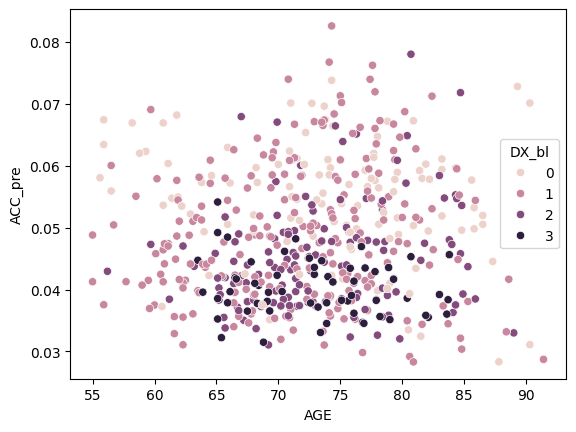

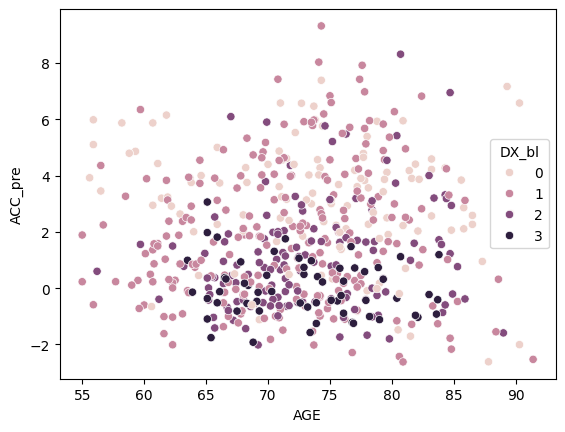

In [10]:
biomarkers_df = pd.DataFrame(df, copy=True)

biomarker_list = new_suvr_cols + ['TAU_bl', 'PTAU_bl']


for biomarker in biomarker_list:
    mean = biomarkers_df[biomarkers_df.DX_bl == 3][biomarker].mean()
    std = biomarkers_df[biomarkers_df.DX_bl == 3][biomarker].std()
    w_score = (df.loc[:,biomarker] - mean) / std
    
    biomarkers_df.loc[:,biomarker] = w_score

plt.figure(0)
sns.scatterplot(x=df.AGE,y=df['ACC_pre'],hue=df.DX_bl)
plt.figure(1)
sns.scatterplot(x=biomarkers_df.AGE,y=biomarkers_df['ACC_pre'],hue=biomarkers_df.DX_bl)


In [11]:
N = len(sustain_biomarkers)

SuStaInLabels = sustain_biomarkers


Z_vals = np.array([[1,2,3]]*N)     # Z-scores for each biomarker
Z_max  = np.array([5]*N)    



In [12]:
N_startpoints = 10
N_S_max = 3
N_iterations_MCMC = int(1e4)
output_folder = os.path.join(os.getcwd(), 'left_right_csf_12feats') # we change this for each of the different tests
dataset_name = 'left_right_csf_12feats'

# Initiate the SuStaIn object
sustain_input = ZscoreSustain(
                              # biomarkers_df[suvr_cols[:3]].values,
                              biomarkers_df[sustain_biomarkers].values,
                              Z_vals,
                              Z_max,
                              SuStaInLabels,
                              N_startpoints,
                              N_S_max, 
                              N_iterations_MCMC, 
                              output_folder, 
                              dataset_name, 
                              False)
if not os.path.isdir(output_folder):
    os.mkdir(output_folder)
    
print("Z_vals.shape:", Z_vals.shape)
print("sustain_input.stage_biomarker_index.shape:", sustain_input.stage_biomarker_index.shape)

Z_vals.shape: (12, 3)
sustain_input.stage_biomarker_index.shape: (1, 36)


In [13]:
samples_sequence,   \
samples_f,          \
ml_subtype,         \
prob_ml_subtype,    \
ml_stage,           \
prob_ml_stage,      \
prob_subtype_stage  = sustain_input.run_sustain_algorithm()

Found pickle file: c:\Users\huw\OneDrive\Documents\Research_Internship\adni-ml\left_right_csf_12feats\pickle_files\left_right_csf_12feats_subtype0.pickle. Using pickled variables for 0 subtype.
Found pickle file: c:\Users\huw\OneDrive\Documents\Research_Internship\adni-ml\left_right_csf_12feats\pickle_files\left_right_csf_12feats_subtype1.pickle. Using pickled variables for 1 subtype.
Found pickle file: c:\Users\huw\OneDrive\Documents\Research_Internship\adni-ml\left_right_csf_12feats\pickle_files\left_right_csf_12feats_subtype2.pickle. Using pickled variables for 2 subtype.


Loading pickle file: c:\Users\huw\OneDrive\Documents\Research_Internship\adni-ml\left_right_csf_12feats/pickle_files/left_right_csf_12feats_subtype2.pickle


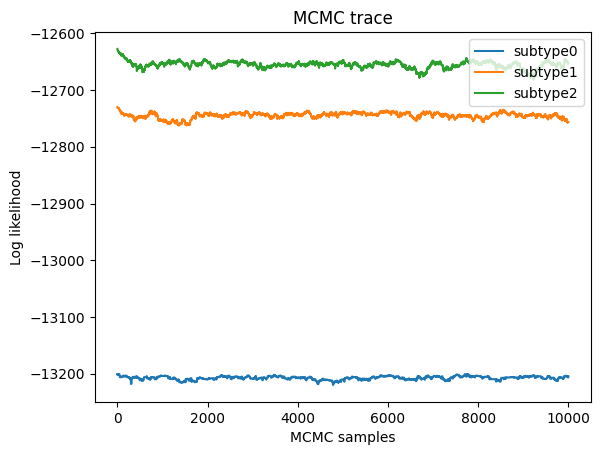

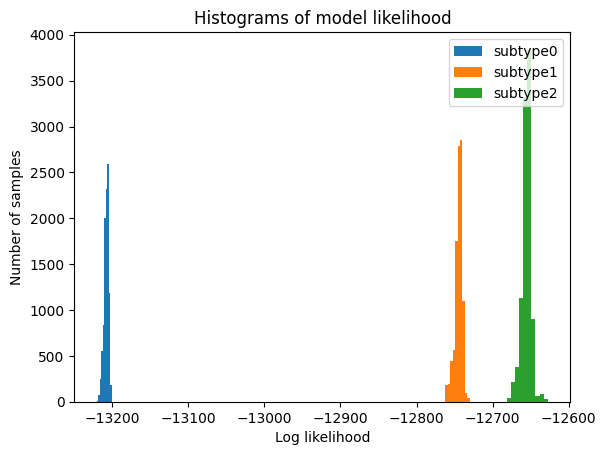

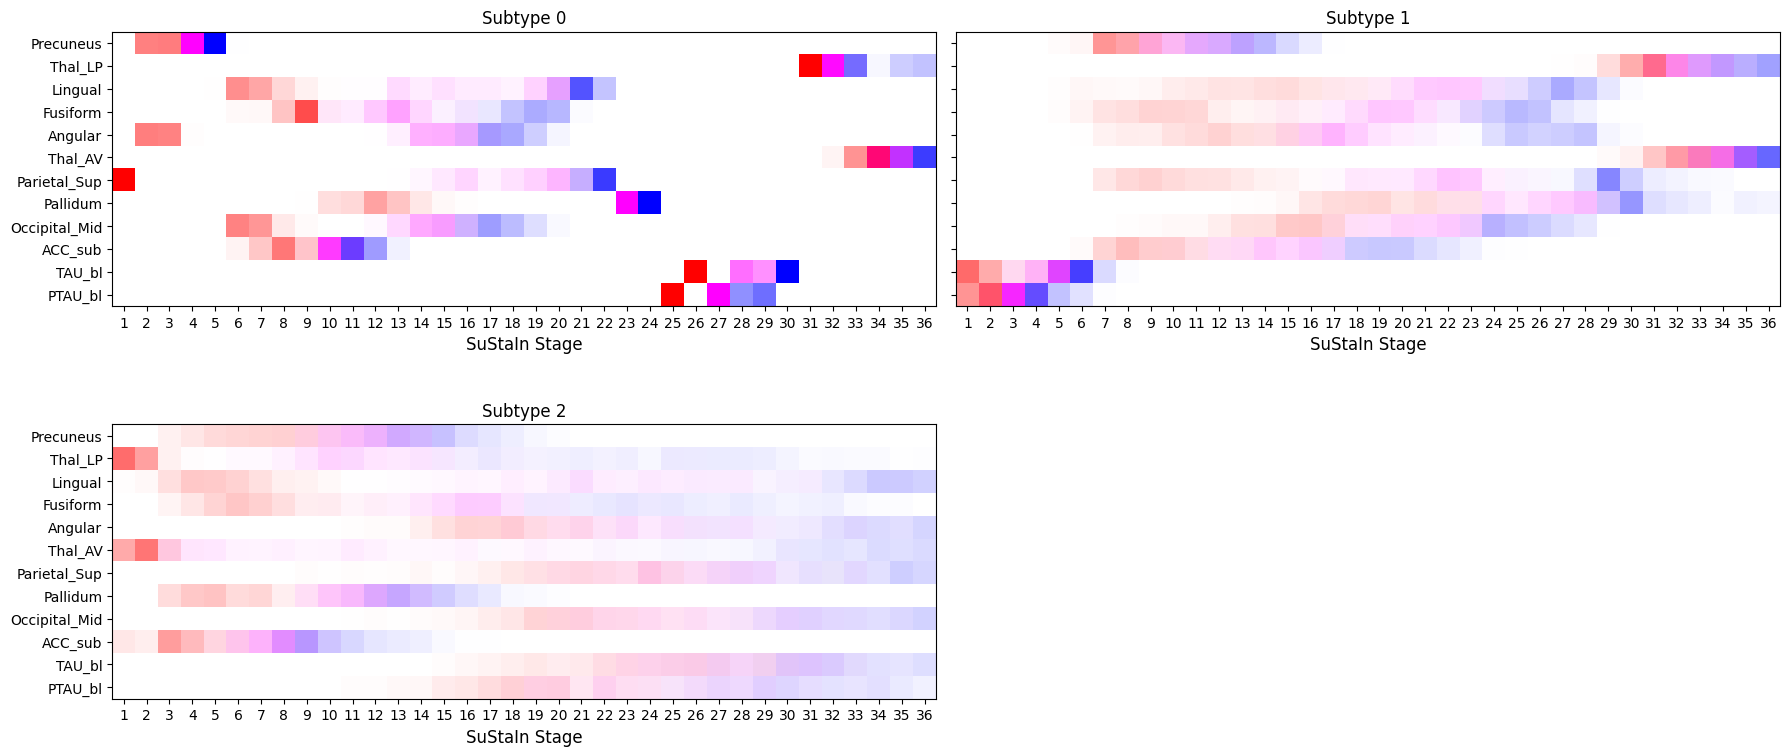

In [14]:
for s in range(N_S_max):
    # load pickle file (SuStaIn output) and get the sample log likelihood values
    pickle_filename_s = output_folder + '/pickle_files/' + dataset_name + '_subtype' + str(s) + '.pickle'
    pk = pd.read_pickle(pickle_filename_s)
    samples_likelihood = pk["samples_likelihood"]
    
    # plot the values as a line plot
    plt.figure(0)
    plt.plot(range(N_iterations_MCMC), samples_likelihood, label="subtype" + str(s))
    plt.legend(loc='upper right')
    plt.xlabel('MCMC samples')
    plt.ylabel('Log likelihood')
    plt.title('MCMC trace')
    
    # plot the values as a histogramp plot
    plt.figure(1)
    plt.hist(samples_likelihood, label="subtype" + str(s))
    plt.legend(loc='upper right')
    plt.xlabel('Log likelihood')  
    plt.ylabel('Number of samples')  
    plt.title('Histograms of model likelihood')
    
s = 2 # 1 split = 2 subtypes
M = len(biomarkers_df) 

# get the sample sequences and f
pickle_filename_s = output_folder + '/pickle_files/' + dataset_name + '_subtype' + str(s) + '.pickle'
print("Loading pickle file:", pickle_filename_s)
pk = pd.read_pickle(pickle_filename_s)
samples_sequence = pk["samples_sequence"]
samples_f = pk["samples_f"]

# use this information to plot the positional variance diagrams
tmp=ZscoreSustain._plot_sustain_model(sustain_input,samples_sequence,samples_f,M, figsize = (18,8), biomarker_labels=sustain_biomarkers, subtype_titles=['Subtype 0', 'Subtype 1', 'Subtype 2'])

In [15]:
zdata = biomarkers_df.copy()

s = 2
pickle_filename_s = output_folder + '/pickle_files/' + dataset_name + '_subtype' + str(s) + '.pickle'
print("Loading pickle file:", pickle_filename_s)
pk = pd.read_pickle(pickle_filename_s)

for variable in ['ml_subtype', # the assigned subtype
                 'prob_ml_subtype', # the probability of the assigned subtype
                 'ml_stage', # the assigned stage 
                 'prob_ml_stage',]: # the probability of the assigned stage
    
    # add SuStaIn output to dataframe
    zdata.loc[:,variable] = pk[variable] 

# let's also add the probability for each subject of being each subtype
for i in range(s):
    zdata.loc[:,'prob_S%s'%i] = pk['prob_subtype'][:,i]


zdata.ml_subtype.value_counts()

Loading pickle file: c:\Users\huw\OneDrive\Documents\Research_Internship\adni-ml\left_right_csf_12feats/pickle_files/left_right_csf_12feats_subtype2.pickle


ml_subtype
0.0    432
1.0     69
2.0     42
Name: count, dtype: int64

In [16]:
zdata[(zdata['ml_subtype'] == 0.0) & (zdata['ml_stage']== 0.0)]

,PTID,TAU_bl,PTAU_bl,ABETA_bl,EXAMDATE,EXAMDATE_bl,DX_bl,DX,AGE,PTGENDER,...,Vermis_7,Vermis_8,Vermis_9,Vermis_10,ml_subtype,prob_ml_subtype,ml_stage,prob_ml_stage,prob_S0,prob_S1
1,100_S_5280,-2.233807,-1.955737,731.8,2015-09-29,2013-09-17,2,2,67.5,0,...,0.628865,0.023323,0.259658,-0.306130,0.0,0.805541,0.0,0.368985,0.805541,0.074010
4,135_S_5269,-2.139915,-1.887424,590.4,2015-09-01,2013-08-20,2,2,64.9,0,...,1.511587,0.880901,1.365481,0.256133,0.0,0.755116,0.0,0.106766,0.755116,0.010690
5,007_S_5265,-0.276825,0.180860,466.1,2015-08-25,2013-08-12,2,2,75.1,1,...,0.717472,0.695861,-0.164410,-1.866826,0.0,0.893815,0.0,0.216567,0.893815,0.098079
7,033_S_5259,-0.798598,-0.932496,1353.0,2015-08-28,2013-08-14,2,2,78.8,1,...,0.255495,-0.492554,-0.502354,-0.080109,0.0,0.849798,0.0,0.394573,0.849798,0.098155
20,009_S_5224,0.112156,0.439577,890.7,2014-02-05,2013-07-25,0,0,78.0,0,...,-1.097367,0.800818,0.530458,-1.666463,0.0,0.725665,0.0,0.237157,0.725665,0.251452
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
533,073_S_5167,-0.119891,-0.157798,1700.0,2015-06-24,2013-06-18,3,2,66.6,0,...,-0.311300,-0.540079,0.121289,0.188362,0.0,0.573476,0.0,0.087410,0.573476,0.078773
534,027_S_5170,-0.673855,-0.566222,1700.0,2015-08-19,2013-05-29,3,2,76.9,0,...,-0.002260,-0.785127,-0.278798,-0.624209,0.0,0.829502,0.0,0.372336,0.829502,0.119104
537,053_S_5208,0.654048,0.170686,1700.0,2013-12-13,2013-06-21,0,0,68.7,0,...,-1.070424,-0.237477,0.702049,0.140821,0.0,0.638685,0.0,0.221360,0.638685,0.330512
538,012_S_5213,0.409929,0.339288,1700.0,2015-09-10,2013-08-15,3,2,65.4,1,...,-0.411904,-0.828362,-0.576215,-1.756051,0.0,0.718594,0.0,0.266950,0.718594,0.214761


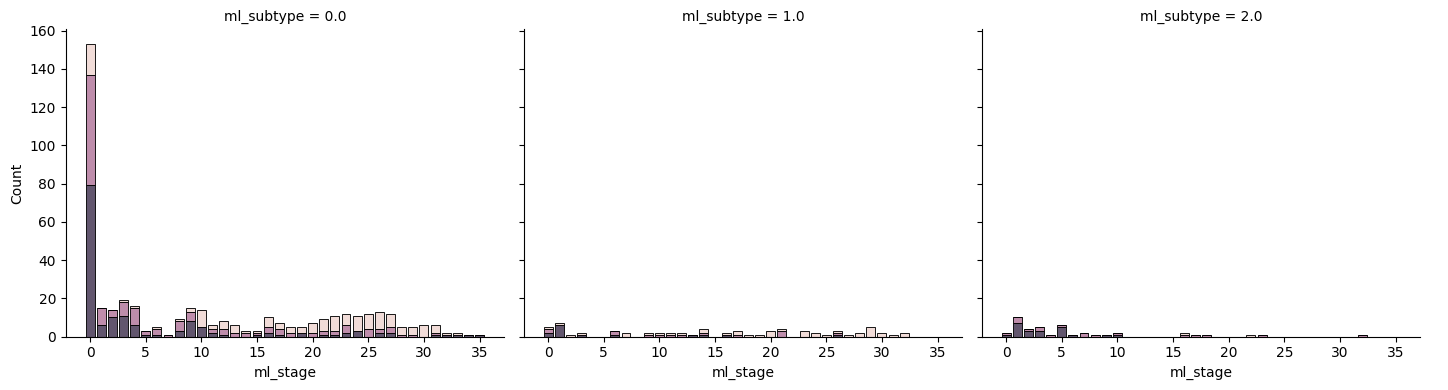

In [17]:
g = sns.FacetGrid(zdata, col="ml_subtype", height=4, aspect=1.2)
g.map_dataframe(sns.histplot, x="ml_stage", hue="DX", multiple="stack", discrete=True, shrink=0.8, legend=True)
g.add_legend()
plt.show()

## Analysis

<Axes: xlabel='ml_subtype'>

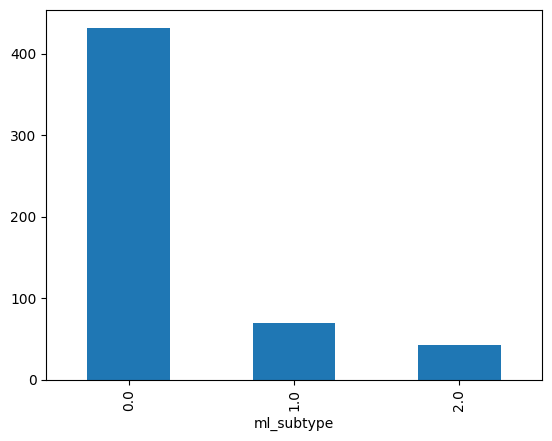

In [18]:
zdata['ml_subtype'].value_counts().sort_index().plot(kind='bar')

Subtype: 0.0
DX_bl
MCI    0.467700
CN     0.289406
AD     0.242894
Name: proportion, dtype: float64
DX_bl
MCI    181
CN     112
AD      94
Name: count, dtype: int64


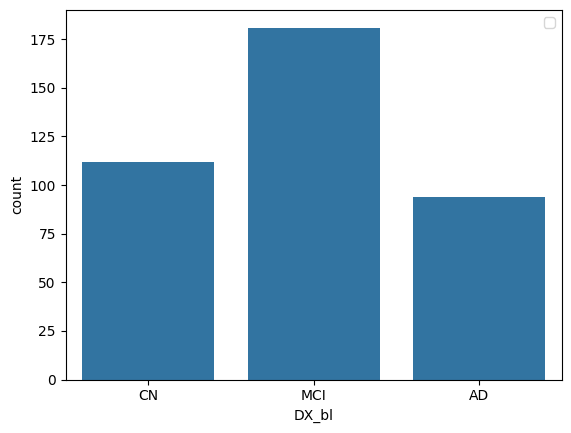

Subtype: 1.0
DX_bl
MCI    0.467742
AD     0.370968
CN     0.161290
Name: proportion, dtype: float64
DX_bl
MCI    29
AD     23
CN     10
Name: count, dtype: int64


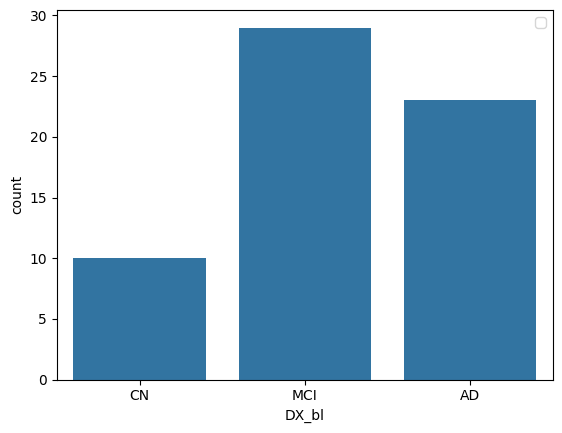

Subtype: 2.0
DX_bl
MCI    0.617647
CN     0.352941
AD     0.029412
Name: proportion, dtype: float64
DX_bl
MCI    21
CN     12
AD      1
Name: count, dtype: int64


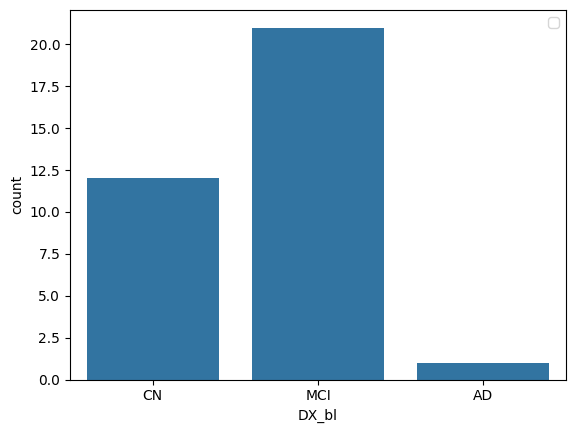

In [19]:
for i in sorted(zdata['ml_subtype'].unique()):
    dx_map = {0.0: 'AD',
              1.0: 'MCI',
              2.0: 'CN'}
    temp_df = zdata[zdata['ml_subtype'] == i]
    temp_df['DX_bl'] = temp_df['DX_bl'].map(dx_map)
    print(f'Subtype: {i}')
    print(temp_df['DX_bl'].value_counts(normalize = True))
    print(temp_df['DX_bl'].value_counts(normalize = False))
    sns.countplot(temp_df, x = 'DX_bl', order=['CN', 'MCI', 'AD'])
    plt.legend()
    plt.show()

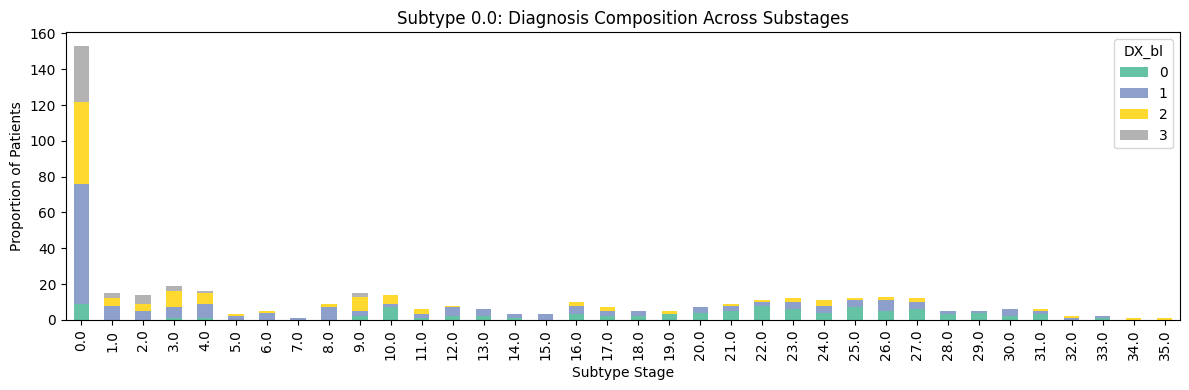

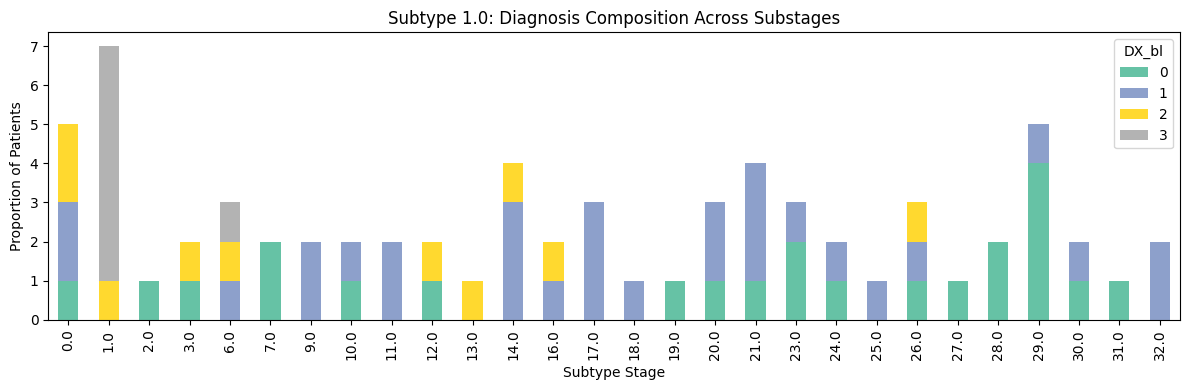

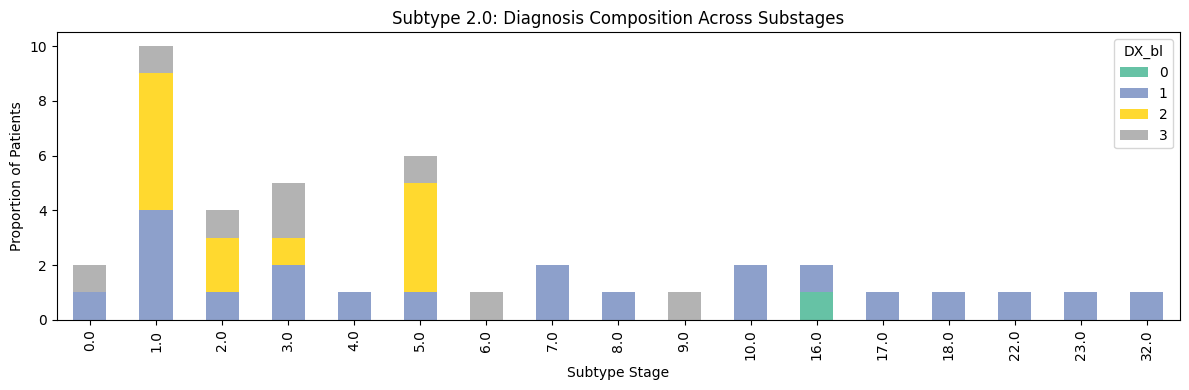

In [20]:
# Create one plot per subtype
for i in sorted(zdata['ml_subtype'].unique()):
    temp_df = zdata[zdata['ml_subtype'] == i]

    # Crosstab: counts of diagnosis per stage
    ctab = pd.crosstab(temp_df['ml_stage'], temp_df['DX_bl'])

    # Normalize to get proportions
    # prop_ctab = ctab.div(ctab.sum(axis=1), axis=0)

    # Plot
    ctab.plot(kind='bar', stacked=True, figsize=(12, 4), colormap='Set2')
    plt.title(f"Subtype {i}: Diagnosis Composition Across Substages")
    plt.xlabel("Subtype Stage")
    plt.ylabel("Proportion of Patients")
    plt.legend(title="DX_bl", loc='upper right')
    plt.tight_layout()
    plt.show()

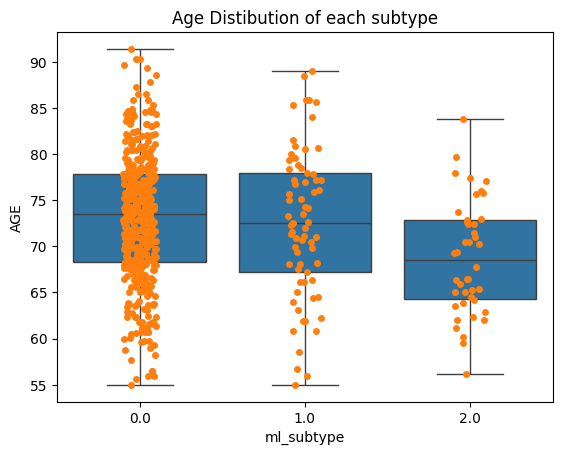

Subtype: 0.0
73.05416666666667
7.0143195432124665
Subtype: 1.0
72.52463768115945
8.005097747081166
Subtype: 2.0
68.78571428571429
6.155329692526094


In [21]:
sns.boxplot(zdata, x = 'ml_subtype', y = 'AGE')
sns.stripplot(zdata, x = 'ml_subtype', y = 'AGE')
plt.title('Age Distibution of each subtype')
plt.show()

for i in sorted(zdata['ml_subtype'].unique()):
    sub = zdata[zdata['ml_subtype'] == i]
    print(f'Subtype: {i}')
    print(sub['AGE'].mean())
    print(sub['AGE'].std())

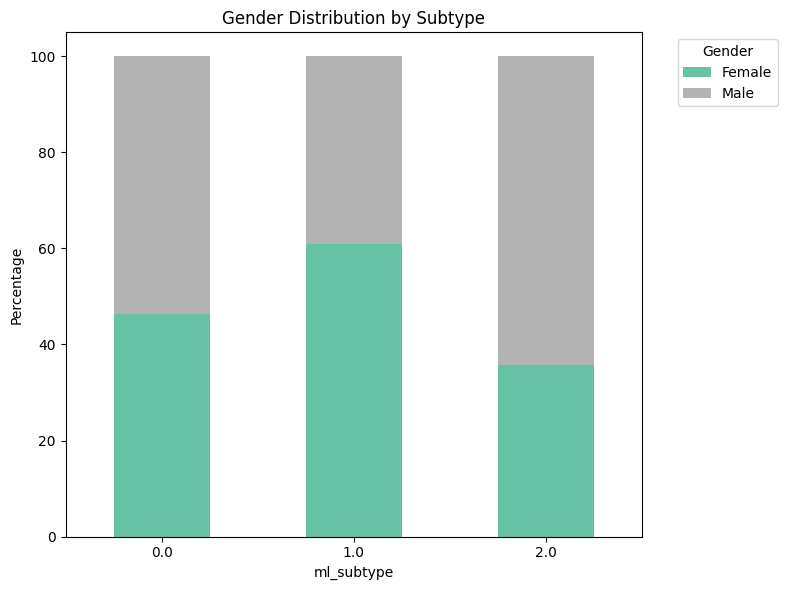

PTGENDER       Female       Male
ml_subtype                      
0.0         46.296296  53.703704
1.0         60.869565  39.130435
2.0         35.714286  64.285714
Chi-squared test statistic: 7.532
Degrees of freedom: 2
p-value: 0.023138747116243242


In [22]:
from scipy.stats import chi2_contingency
gender_map = {0: 'Male', 1: 'Female'}
zdata['PTGENDER'] = zdata['PTGENDER'].map(gender_map)

gender_counts = zdata.groupby(['ml_subtype', 'PTGENDER']).size().unstack(fill_value=0)
gender_percent = gender_counts.div(gender_counts.sum(axis=1), axis=0) * 100
ax = gender_percent.plot(kind='bar', stacked=True, figsize=(8, 6), colormap='Set2')

plt.ylabel('Percentage')
plt.title('Gender Distribution by Subtype')
plt.legend(title='Gender', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

print(gender_percent)

chi2, p, dof, expected = chi2_contingency(gender_counts.values)

print("Chi-squared test statistic:", round(chi2, 3))
print("Degrees of freedom:", dof)
print("p-value:", p)

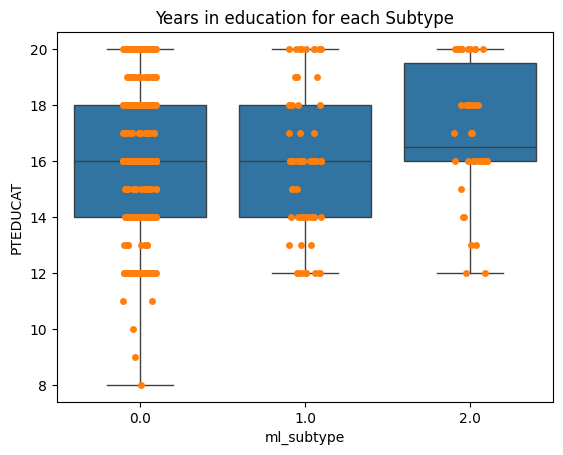

Subtype: 0.0
16.328703703703702
2.6025705988021905
Subtype: 1.0
16.0
2.5724787771376323
Subtype: 2.0
17.0
2.3373948391631103


In [23]:
sns.boxplot(zdata, x = 'ml_subtype', y = 'PTEDUCAT')
sns.stripplot(zdata, x = 'ml_subtype', y = 'PTEDUCAT')
plt.title('Years in education for each Subtype')
plt.show()

for i in sorted(zdata['ml_subtype'].unique()):
    sub = zdata[zdata['ml_subtype'] == i]
    print(f'Subtype: {i}')
    print(sub['PTEDUCAT'].mean())
    print(sub['PTEDUCAT'].std())


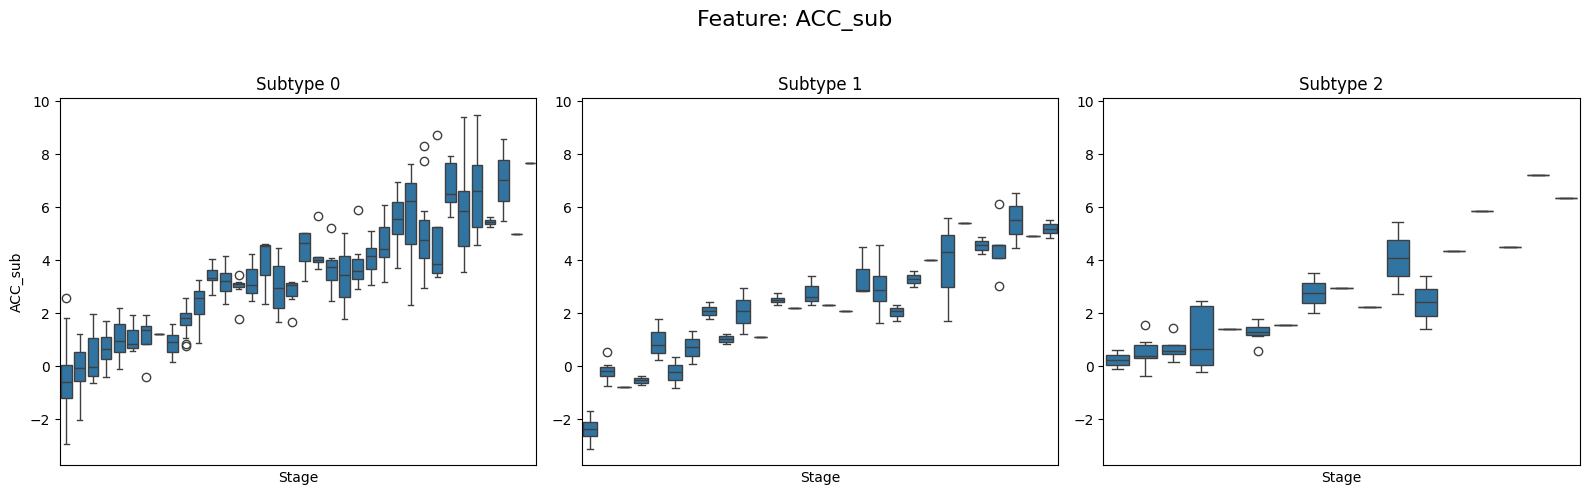

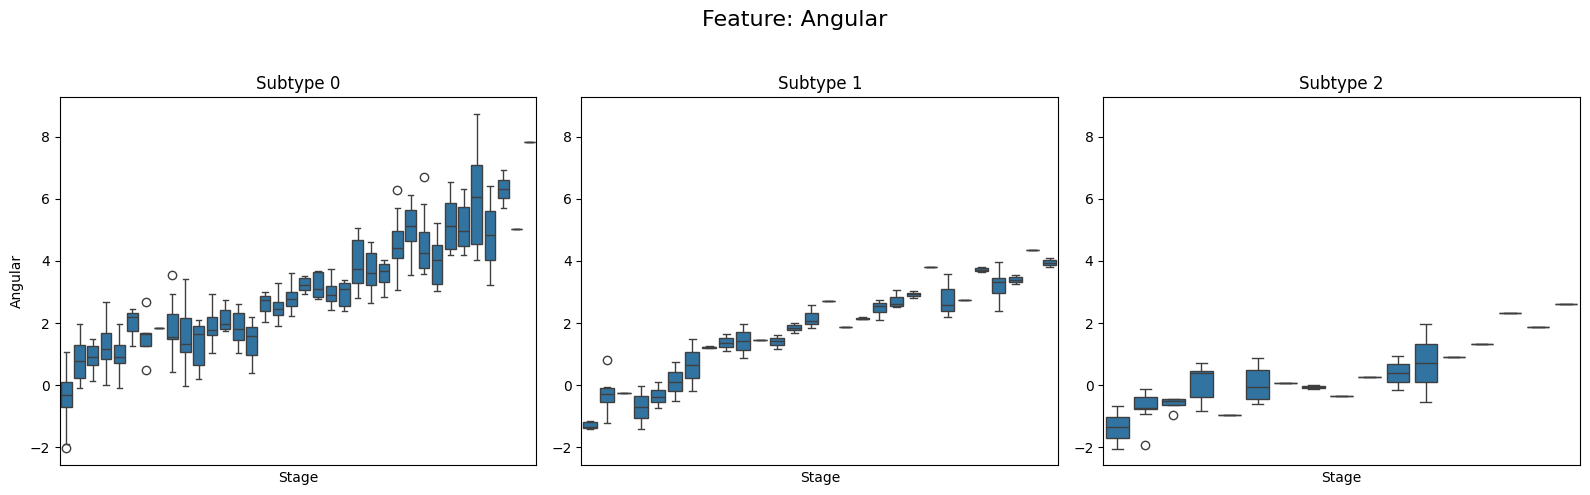

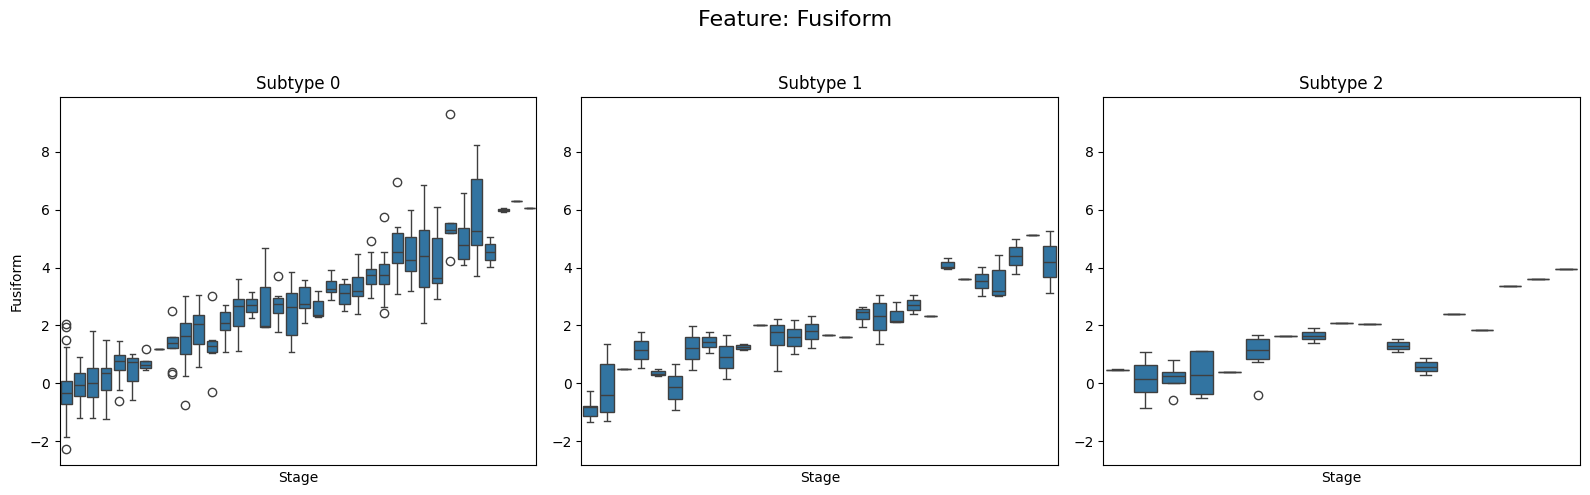

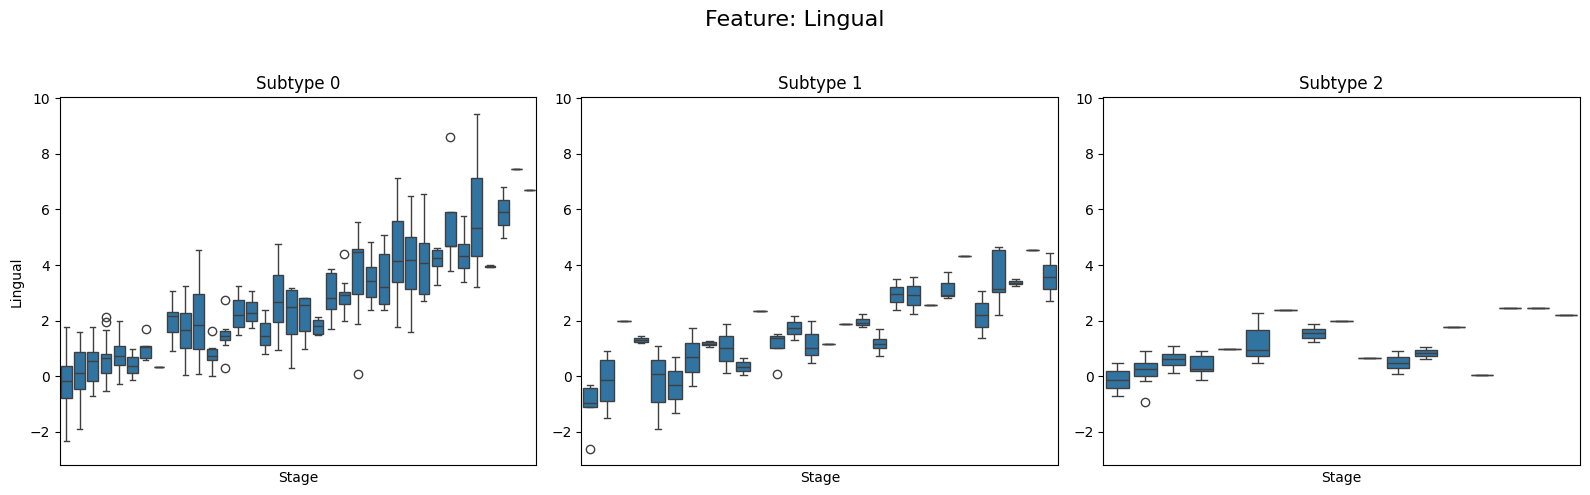

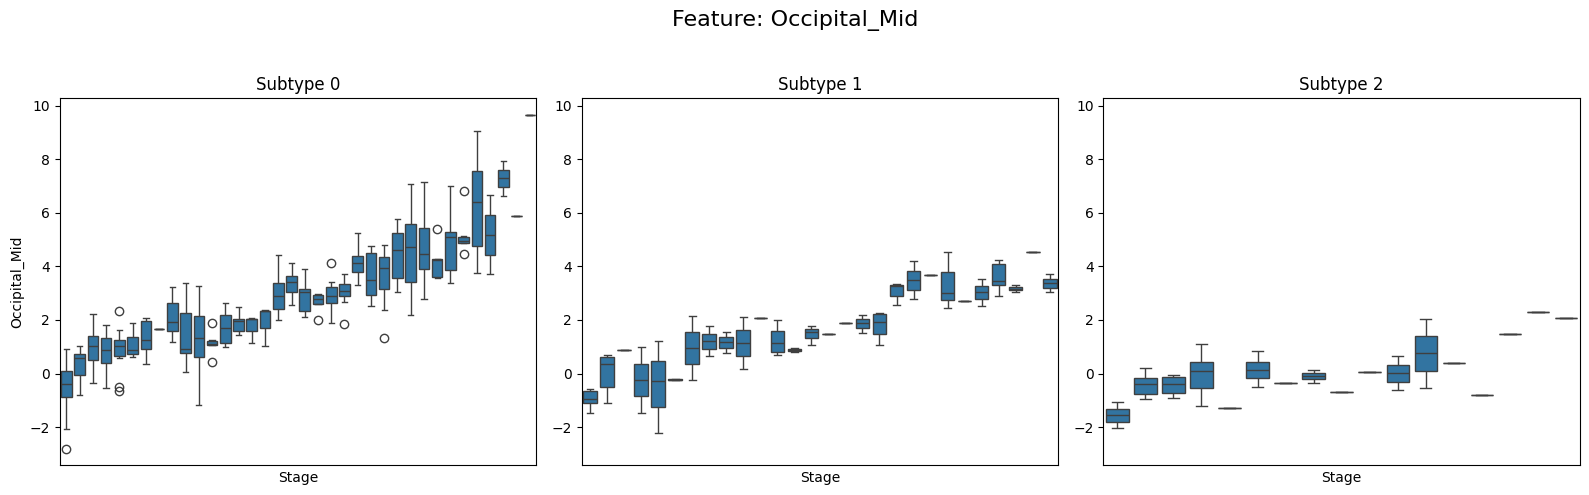

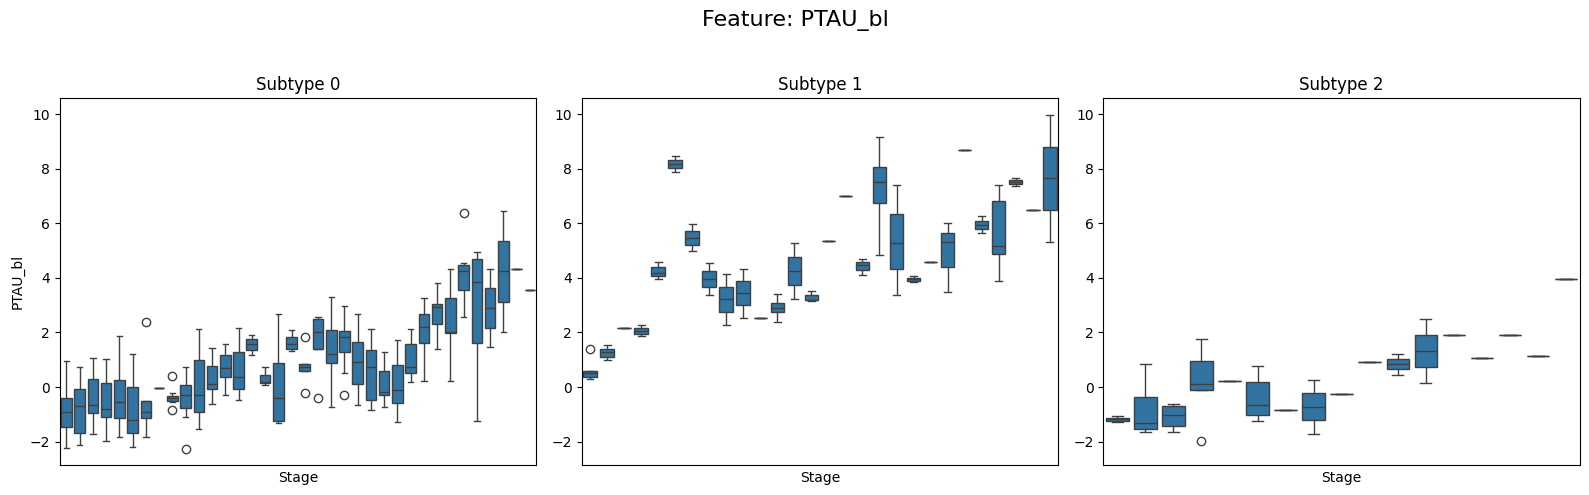

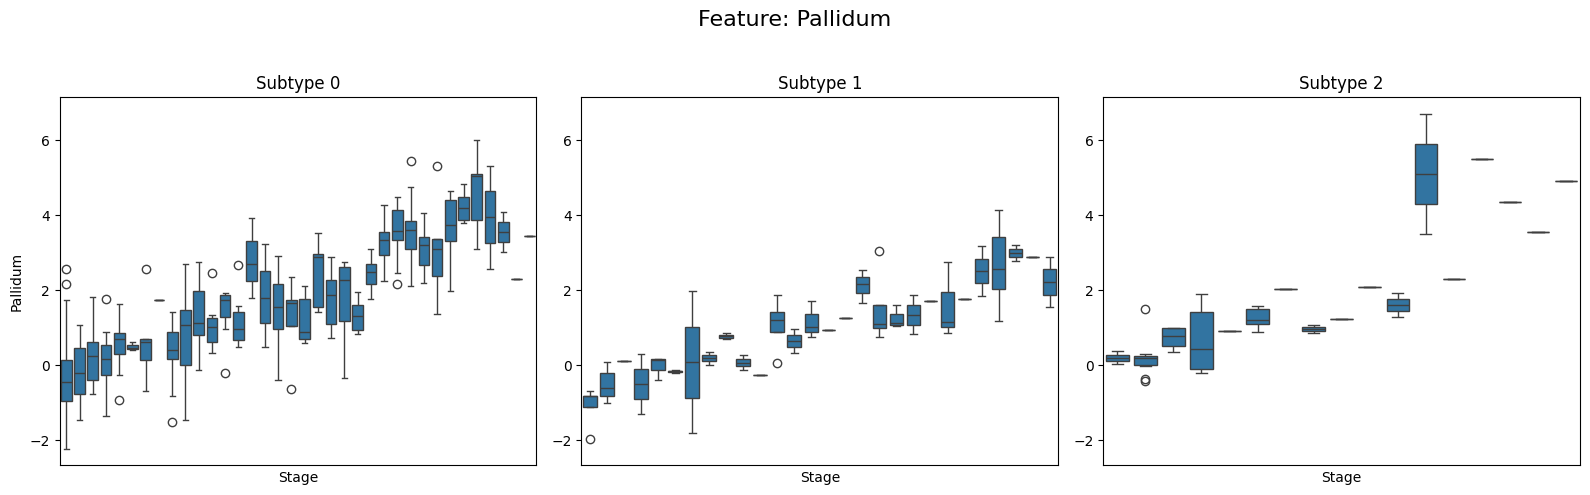

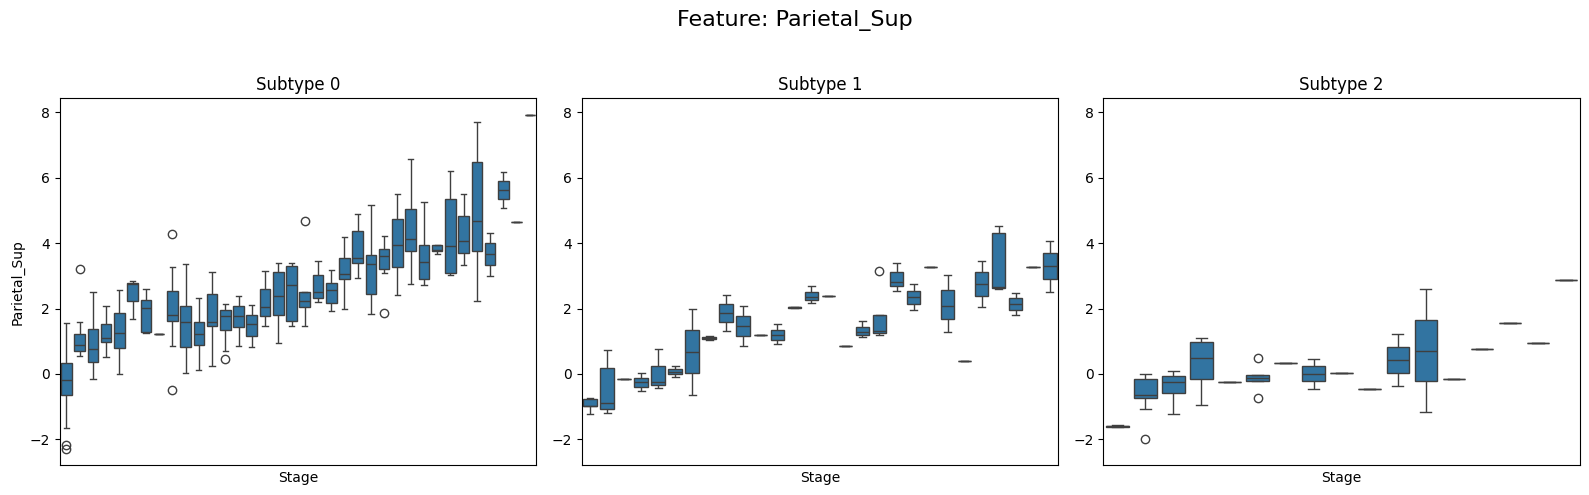

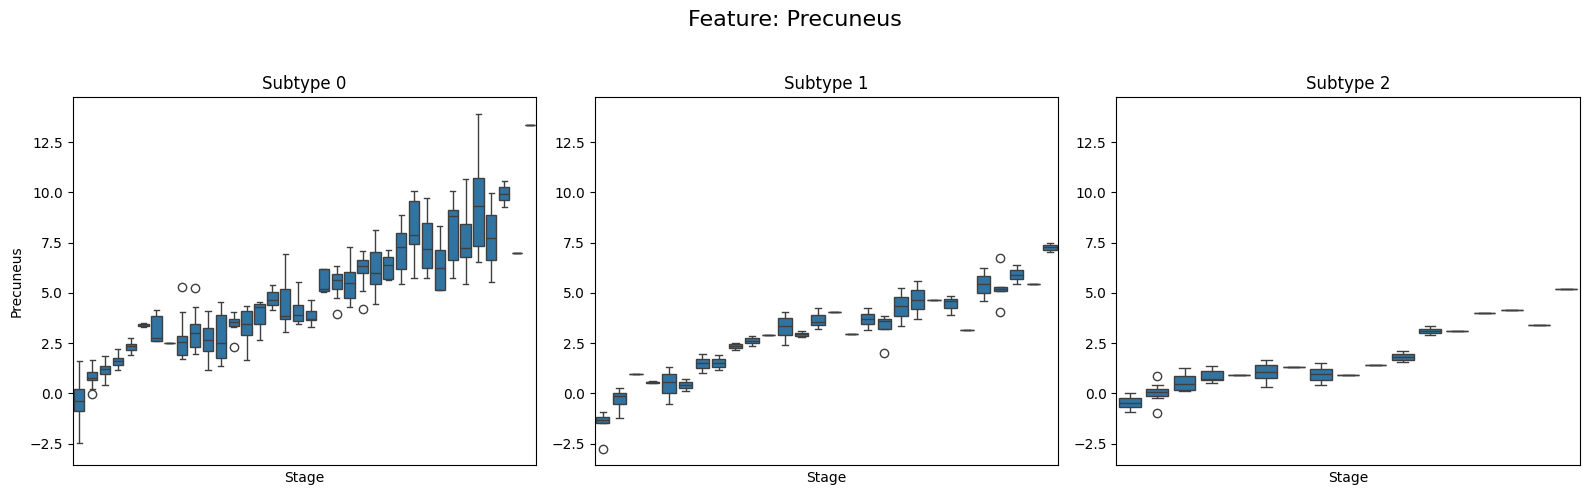

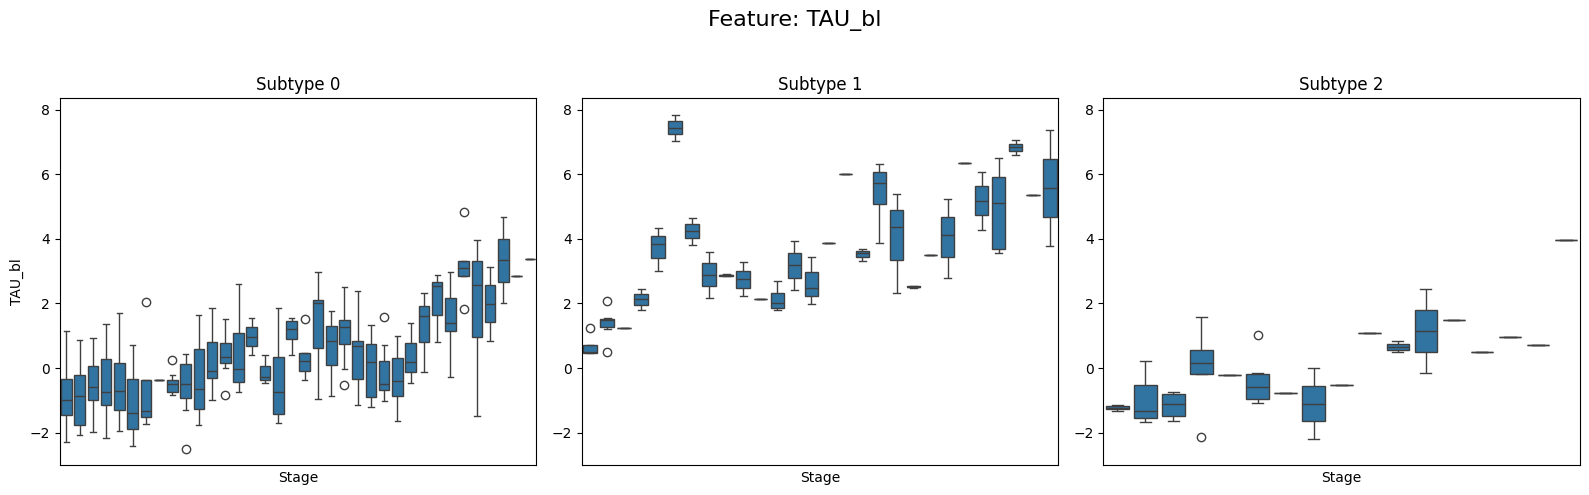

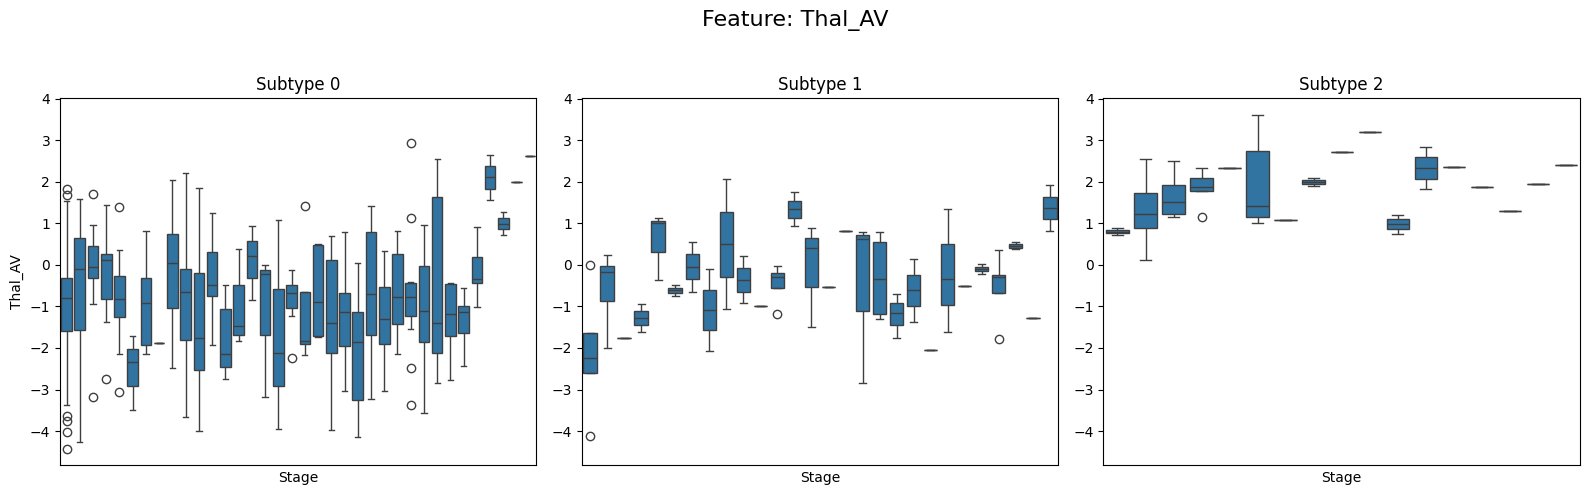

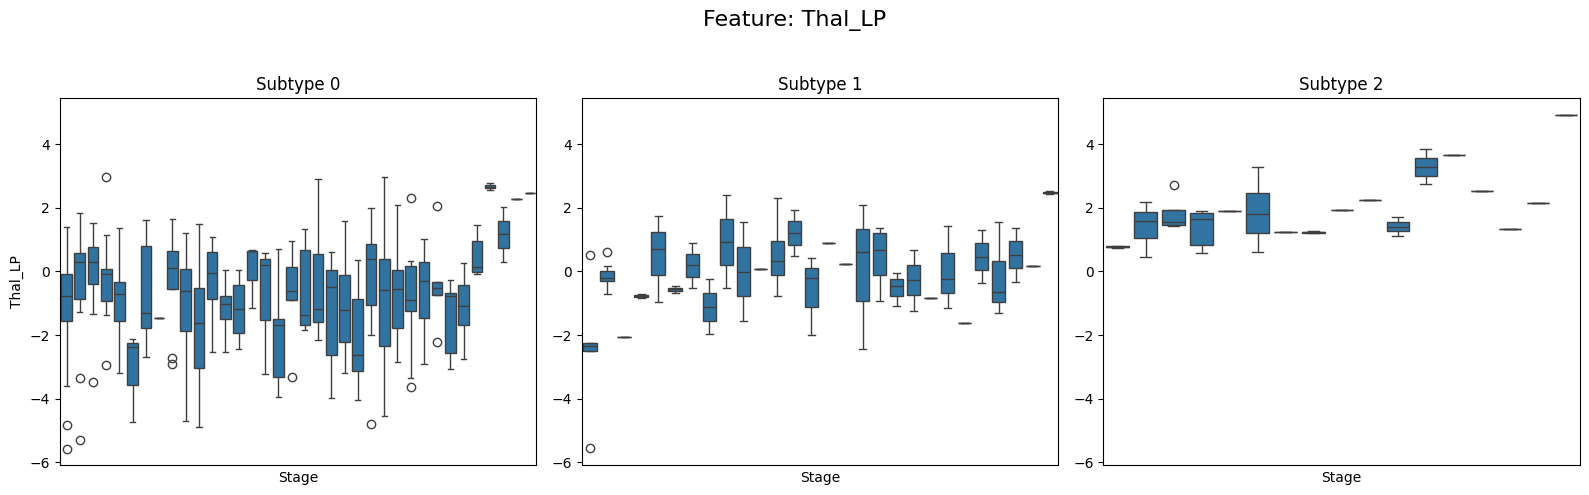

In [24]:
subtypes = [0, 1, 2]
features_to_view = sorted(SuStaInLabels)
for feature in features_to_view:
    fig, axs = plt.subplots(nrows=1, ncols=len(subtypes), figsize=(16, 5), sharey=True)
    fig.suptitle(f'Feature: {feature}', fontsize=16)

    for idx, subtype in enumerate(subtypes):
        sub = zdata[zdata['ml_subtype'] == subtype].copy()
        sub['ml_stage'] = sub['ml_stage'].astype(int)
        sns.boxplot(data=sub, x='ml_stage', y=feature, ax=axs[idx])
        axs[idx].set_title(f'Subtype {subtype}')
        axs[idx].set_xlabel('Stage')
        axs[idx].set_ylabel(feature)
        axs[idx].tick_params(top=False, bottom=False, left=True, right=False,
                labelleft=True, labelbottom=False)
        

    plt.tight_layout(rect=[0, 0, 1, 0.95])  
    plt.show()

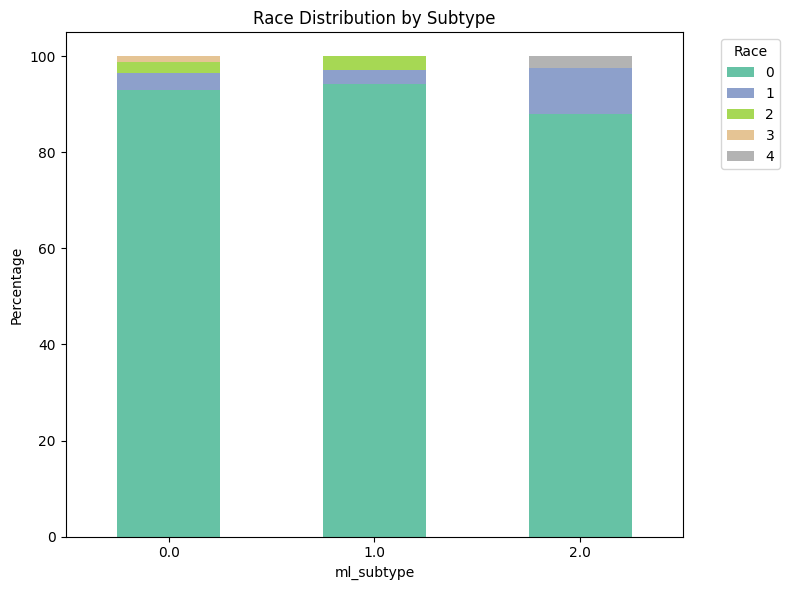

In [25]:

race_counts = zdata.groupby(['ml_subtype', 'PTRACCAT']).size().unstack(fill_value=0)
race_percent = race_counts.div(race_counts.sum(axis=1), axis=0) * 100
ax = race_percent.plot(kind='bar', stacked=True, figsize=(8, 6), colormap='Set2')

plt.ylabel('Percentage')
plt.title('Race Distribution by Subtype')
plt.legend(title='Race', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

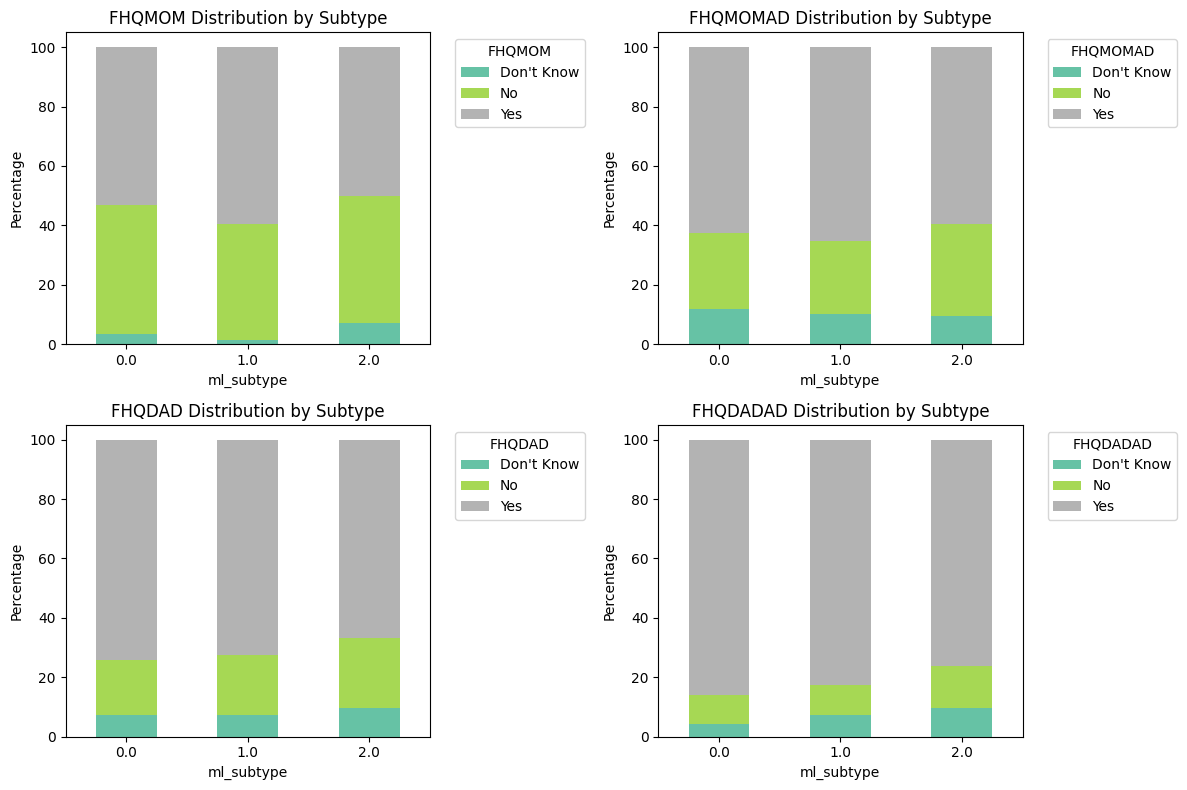

In [26]:
fhq = ['FHQMOM', 'FHQMOMAD', 'FHQDAD', 'FHQDADAD']
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))
axs = axs.flatten()

fhq_map ={
    0.0: 'Yes',
    1.0: 'No',
    2.0: 'Don\'t Know'
}

for idx, col in enumerate(fhq):
    ax = axs[idx]
    
    # Calculate counts and percentages
    zdata[col] = zdata[col].map(fhq_map)
    counts = zdata.groupby(['ml_subtype', col]).size().unstack(fill_value=0)
    percent = counts.div(counts.sum(axis=1), axis=0) * 100

    # Plot into subplot axis
    percent.plot(kind='bar', stacked=True, ax=ax, colormap='Set2')

    ax.set_title(f'{col} Distribution by Subtype')
    ax.set_ylabel('Percentage')
    ax.set_xlabel('ml_subtype')
    ax.legend(title=col, bbox_to_anchor=(1.05, 1), loc='upper left')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=0)

plt.tight_layout()
plt.show()